# tinylm demo

Showing what a 2.7M parameter transformer learns from 1MB of Shakespeare.

The model is a decoder-only GPT (6 layers, 192d, 6 heads) with a character-level tokenizer. Every component is built from scratch in PyTorch, no pre-built transformer modules.

In [1]:
import torch
import matplotlib.pyplot as plt
from generate import load_model, generate

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = 'mps'

model, tok, config = load_model('checkpoints/model.pt', device)
model.eval()

n_params = sum(p.numel() for p in model.parameters())
print(f'Model: {n_params:,} parameters')
print(f'Config: {config.n_layer} layers, {config.n_embd}d, {config.n_head} heads, {config.block_size} context')
print(f'Vocab: {config.vocab_size} characters')
print(f'Device: {device}')

Model: 2,731,200 parameters
Config: 6 layers, 192d, 6 heads, 256 context
Vocab: 65 characters
Device: mps


## Training loss

Trained for 5K steps on Apple Silicon (MPS), about 30 minutes. The training uses cosine LR decay with linear warmup, which is why the curve flattens out smoothly at the end rather than bouncing around.

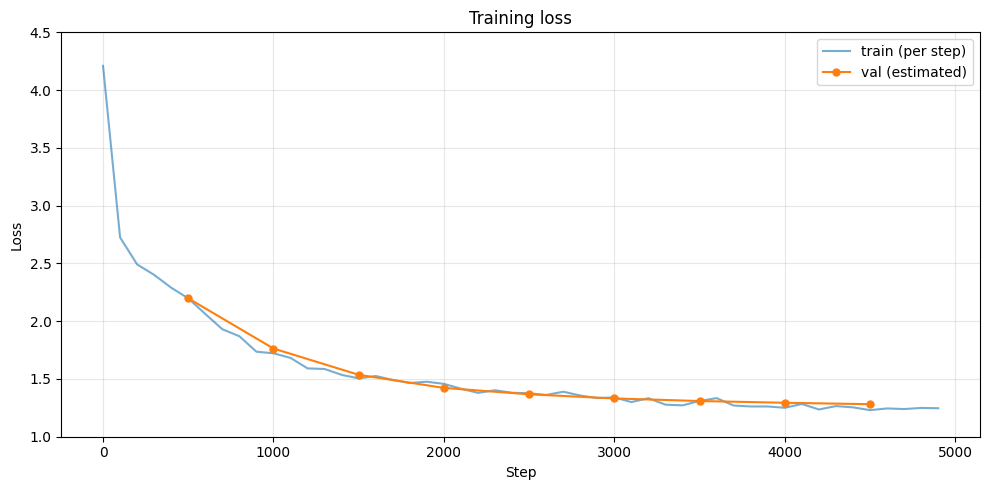

Final train loss: 1.2465
Final val loss:   1.2815
Gap:              0.0350


In [2]:
# loss from the training run
steps = list(range(0, 5000, 100))
train_loss = [
    4.2097, 2.7251, 2.4912, 2.4007, 2.2897, 2.1976, 2.0625, 1.9304, 1.8694, 1.7358,
    1.7222, 1.6823, 1.5913, 1.5863, 1.5353, 1.5051, 1.5256, 1.4913, 1.4649, 1.4759,
    1.4572, 1.4156, 1.3797, 1.4020, 1.3805, 1.3761, 1.3615, 1.3895, 1.3566, 1.3343,
    1.3402, 1.2998, 1.3333, 1.2773, 1.2714, 1.3100, 1.3339, 1.2698, 1.2618, 1.2617,
    1.2504, 1.2835, 1.2357, 1.2651, 1.2542, 1.2300, 1.2448, 1.2394, 1.2493, 1.2465,
]

val_steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
val_loss = [2.1979, 1.7632, 1.5359, 1.4225, 1.3672, 1.3313, 1.3090, 1.2939, 1.2815]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(steps, train_loss, alpha=0.6, label='train (per step)')
ax.plot(val_steps, val_loss, 'o-', color='tab:orange', markersize=5, label='val (estimated)')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Training loss')
ax.legend()
ax.set_ylim(1.0, 4.5)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final train loss: {train_loss[-1]:.4f}')
print(f'Final val loss:   {val_loss[-1]:.4f}')
print(f'Gap:              {val_loss[-1] - train_loss[-1]:.4f}')

The train/val gap is small (~0.04), so the model isn't just memorizing the training data. There's still room to train longer or scale up, but for a character-level model on 1MB of text, this is about where you'd expect it to plateau.

## Generation at different temperatures

Temperature controls randomness. Lower = the model picks safer, more predictable tokens. Higher = more variety but also more gibberish.

I also use top-k sampling (k=40) to cut off the long tail of unlikely tokens, which helps at all temperatures.

In [3]:
torch.manual_seed(42)

for temp in [0.5, 0.8, 1.2]:
    text = generate(model, tok, config, prompt='ROMEO:', max_new_tokens=300,
                    temperature=temp, top_k=40, device=device)
    print(f'--- temperature={temp} ---')
    print(text)
    print()

--- temperature=0.5 ---
ROMEO:
A happy thou the prince of thy brain,
And thou the point of thy son through and blood,
Thou art thy consent by the world thou wilt not
And ever tears thy son a scrace to thy land.

ROMEO:
What, that will thy sovereign, that she shall be
In the hand of the contract is the streets
That call'd of the 



--- temperature=0.8 ---
ROMEO:
I am made a word; for any are mock,
And that thou wilt be the kingdom of the cold.

JULIET:
What ever are did I  do; for I shall report
The scope that I was done a foe?

ROMEO:
The time world is rest that thy duke three.

FRIAR LAURENCE:
I have not; so shortly of thee,
Contry the grief the did I ha



--- temperature=1.2 ---
ROMEO:
Be prize the empty brain'd for that sea
chaster?
What, shows srought is all toads the numbersed?
But nocked my challe place so bear doth thy plent; not
under subjects by so gift I f myself.

JULIET:
Yet mighty dowry, or exercise
Upon in give: if all of I restroute,
On villain, thee to thy friend is



At 0.5 the model plays it safe: real character names, proper dialogue formatting, repetitive but coherent structure. At 1.2 it gets creative but starts making up words. 0.8 is the sweet spot for this model.

## More prompts

The model has only seen Shakespeare, so it doesn't know about anything else. But it does pick up on character names and tries to stay in-character (at least structurally).

In [4]:
torch.manual_seed(0)

prompts = ['HAMLET:', 'KING HENRY:', 'JULIET:']
for prompt in prompts:
    text = generate(model, tok, config, prompt=prompt, max_new_tokens=200,
                    temperature=0.8, top_k=40, device=device)
    print(f'--- {prompt} ---')
    print(text)
    print()

--- HAMLET: ---
HAMLET:
That hand you shall report your mutinous maid.

CLARENCE:
Hath rather to her fly the first and graves,
And you shall not be assured my brother.

CLARENCE:
Thou say'st no more accustom of dust.

KING 



--- KING HENRY: ---
KING HENRY:
What, shall I play thee?

KING HENRY VI:
What is the mother is the dead?

HENRY BOLINGBROKE:
Now, now might I will stay by precious me
That make a honour appear of me.

KING RICHARD III:
Have the dar



--- JULIET: ---
JULIET:
O, good my lord, and here love hence youth,
That she not have I deserved.

LEONTES:
O hand!
She's not the ghost?

MENENIUS:
Your infection's lady.

HERMIONE:
Why, my lord?

HASTINGS:
I told your good



## What the model actually learns

This is a character-level model predicting one character at a time, working from just 1MB of training data. It can't understand meaning. But it picks up a surprising amount of structure:

**What it gets right:**
- Character names (ROMEO, JULIET, KING HENRY, GLOUCESTER, etc.)
- Dialogue format (NAME: followed by lines of speech)
- Verse-like line lengths and rhythm
- Shakespearean vocabulary (thou, thy, hath, doth, wherefore)
- Stage directions and scene structure

**What it doesn't get:**
- Actual meaning or coherent sentences
- Consistent plot or conversation flow
- Grammar beyond short phrases

For real text generation you'd need a much larger model with a subword tokenizer (BPE or similar), trained on way more data. The point of this project was to build every transformer component from scratch and understand how they work, not to compete with GPT-2.